# Классификация постов из твиттера

В файле train.csv содержится 30 000 постов, каждый из которых сопоставлен с одним из 13 классов эмоций.

*Цель проекта:*

    - Предсказать эмоцию для 10 000 постов, содержащихся в test.csv,
    - Результат предсказания записать в test_predictions.csv, 
    - Метрика качества - accuracy.
    
## Подготовка данных к работе

### Изучим данные из файла

Импортируем необходимые нам алгоритмы и функции:

In [1]:
#!pip install torch -U
#!pip install transformers -U
#!pip3 install pymystem3 -U

import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

import torch
import transformers
import numpy as np
from tqdm import notebook

from pymystem3 import Mystem
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

Импортируем данные.

Введем тренировочный датасет - data_train, и тестовый - data_test.

In [2]:
data_train = pd.read_csv('train.csv')
pd.set_option('display.max_columns', None)
print('Посмотрим на первые 5 строк датафрейма data_train:')
display(data_train.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(data_train.info())

Посмотрим на первые 5 строк датафрейма data_train:


,Unnamed: 0,tweet_id,sentiment,content
0,0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,4,1956968416,neutral,@dannycastillo We want to trade with someone w...




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30000 non-null  int64 
 1   tweet_id    30000 non-null  int64 
 2   sentiment   30000 non-null  object
 3   content     30000 non-null  object
dtypes: int64(2), object(2)
memory usage: 937.6+ KB


None

Данные в тренировочном датасете представляют собой id записи (столбец 'tweet_id'), целевой признак - 'sentiment' и сам пост (столбец 'content').

Столбец 'Unnamed: 0' указывает на индекс поста. В нем у нас нет необходимости. Его можно исключить из исследования.

Столбец 'tweet_id' также не является для нас признаком, в нем нет необходимости. Но прежде чем мы исключим его из исследования, проверим данные на наличие дубликатов.

In [3]:
data_train.drop(['Unnamed: 0'], axis = 1, inplace = True)

data_train.duplicated().sum()

0

Задублированных записей нет.

Исключаем столбец 'tweet_id'.

In [4]:
data_train.drop(['tweet_id'], axis = 1, inplace = True)
print('Посмотрим на первые 5 строк датафрейма data_train после исключения столбцов Unnamed: 0 и tweet_id:')
display(data_train.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(data_train.info())

Посмотрим на первые 5 строк датафрейма data_train после исключения столбцов Unnamed: 0 и tweet_id:


,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  30000 non-null  object
 1   content    30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB


None

In [5]:
data_test = pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
print('Посмотрим на первые 5 строк датафрейма data_test:')
display(data_test.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(data_test.info())

Посмотрим на первые 5 строк датафрейма data_test:


,Unnamed: 0,tweet_id,content
0,30000,1751430947,is hangin with the love of my life. Tessa McCr...
1,30001,1751430999,I've Got An Urge To Make Music Like Massively....
2,30002,1751431011,@lacrossehawty rofl uh huh
3,30003,1751431016,"@fankri haha! thanks, Tiff it went well, but..."
4,30004,1751431033,@alyssaisntcool hahah i loveeee him though.




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   tweet_id    10000 non-null  int64 
 2   content     10000 non-null  object
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


None

Данные в тестовом датасете также представляют собой id записи (столбец 'tweet_id') и сам текст поста (столбец 'content').

Повторим процедуру, исключим столбец 'Unnamed: 0', проверим данные на наличие дубликатов, исключим столбец 'tweet_id'.

In [6]:
data_test.drop(['Unnamed: 0'], axis = 1, inplace = True)

data_test.duplicated().sum()

0

In [7]:
data_test.drop(['tweet_id'], axis = 1, inplace = True)
print('Посмотрим на первые 5 строк датафрейма data_test после исключения столбцов Unnamed: 0 и tweet_id:')
display(data_test.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(data_test.info())

Посмотрим на первые 5 строк датафрейма data_test после исключения столбцов Unnamed: 0 и tweet_id:


,content
0,is hangin with the love of my life. Tessa McCr...
1,I've Got An Urge To Make Music Like Massively....
2,@lacrossehawty rofl uh huh
3,"@fankri haha! thanks, Tiff it went well, but..."
4,@alyssaisntcool hahah i loveeee him though.




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


None

Данные готовы к дальнейшему этапу подготовки.

### BERT

Один из вариантов подготовки текстов к обучению модели классификации - это создание векторных представлений на базе **BERT**.

Построить векторы текстов нам поможет предобученная многоязычная модель BERT-base.

*Данный метод был выполнен локально и его результат - векторные представления были записаны в файл.*

*Дальнейший код представлен исключительно в целях ознакомления, он закоментирован и запускать его нет необходимости.*

Инициализируем токенизатор как объект класса **BertTokenizer()**.

Передадим ему аргумент **vocab_file** — это файл со словарём, на котором обучалась модель.

In [8]:
#tokenizer = transformers.BertTokenizer(vocab_file = 'vocab.txt')

Токенизируем каждую запись на тренировочном и тестовом датасетах:

In [9]:
#data_list = ['data_train', 'data_test']

#tokenized_train = data_train['content'].apply(lambda x:tokenizer.encode(x, add_special_tokens = True, truncation=True, max_length=512))
#tokenized_test = data_test['content'].apply(lambda x:tokenizer.encode(x, add_special_tokens = True, truncation=True, max_length=512))

Пусть стандартной длиной вектора n будет длина наибольшего во всём датасете вектора. Остальные векторы дополним нулями:

In [10]:
#max_len_train = 0
#max_len_test = 0

#for i in tokenized_train.values:
#    if len(i) > max_len_train:
#        max_len_train = len(i)
#padded_train = np.array([i + [0] * (max_len_train - len(i)) for i in tokenized_train.values])
    
#for i in tokenized_test.values:
#    if len(i) > max_len_test:
#        max_len_test = len(i)
#padded_test = np.array([i + [0] * (max_len_train - len(i)) for i in tokenized_test.values])

Теперь поясним модели, что нули не несут значимой информации.

Отбросим эти токены и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения:

In [11]:
#attention_mask_train = np.where(padded_train != 0, 1, 0)
#attention_mask_test = np.where(padded_test != 0, 1, 0)

Инициализируем конфигурацию **BertConfig**.

В качестве аргумента передадим ей **JSON-файл** с описанием настроек модели.

In [12]:
#config = transformers.BertConfig.from_json_file('bert_config.json')

Инициализируем саму модель класса **BertModel**.

Передадим ей файл с предобученной моделью:

In [13]:
#model = transformers.BertModel.from_pretrained('pytorch_model.bin', config = config) 

Эмбеддинги модель BERT создаёт **батчами**. Чтобы хватило оперативной памяти, сделаем размер батча небольшим:

In [14]:
#batch_size = 100

Сделаем цикл по батчам. Отображать прогресс будет функция **notebook()**.

Преобразуем данные в формат **тензоров** — многомерных векторов в библиотеке torch.

Тип данных **LongTensor** хранит числа в «длинном формате», то есть выделяет на каждое число 64 бита.

Чтобы получить эмбеддинги для батча, передадим модели данные и маску.

Для ускорения вычисления функцией **no_grad()** в библиотеке torch укажем, что градиенты не нужны: модель BERT обучать не будем.

Из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов.

*P.S. Процесс получения эмбеддингов довольно долгий. Для его ускорения можно воспользоваться аппаратным ускорителем GPU в COLAB. Тем не менее, процесс завершился успешно без применения дополнительной мощности.*

*Вот так проходил процесс создания эмбеддингов:*

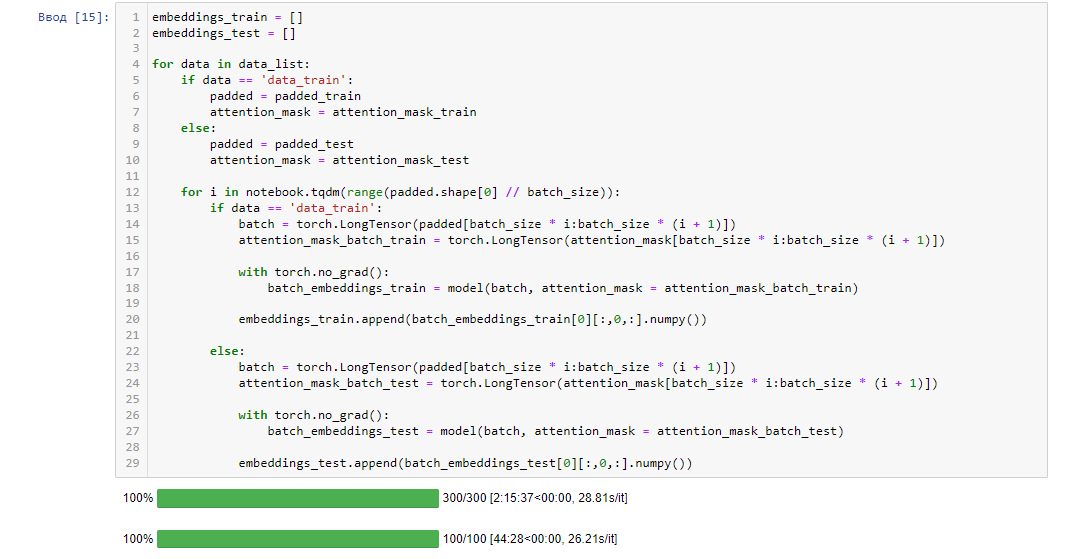

*Чтобы избежать повторного запуска и такого же длительного ожидания создания эмбеддингов, мы собрали все эмбеддинги в матрицу признаков вызвав функции concatenate() и сохранили их в файлах data_features_train и data_features_test. В дальнейшем будем выгружать векторизованные признаки из файла.*

In [15]:
#embeddings_train = []
#embeddings_test = []

#for data in data_list:
#    if data == 'data_train':
#        padded = padded_train
#        attention_mask = attention_mask_train
#    else:
#        padded = padded_test
#        attention_mask = attention_mask_test

#    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
#        if data == 'data_train':
#            batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)]) 
#            attention_mask_batch_train = torch.LongTensor(attention_mask[batch_size * i:batch_size * (i + 1)]) 
    
#            with torch.no_grad():
#                batch_embeddings_train = model(batch, attention_mask = attention_mask_batch_train)
    
#            embeddings_train.append(batch_embeddings_train[0][:,0,:].numpy())
        
#        else:
#            batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)]) 
#            attention_mask_batch_test = torch.LongTensor(attention_mask[batch_size * i:batch_size * (i + 1)]) 
    
#            with torch.no_grad():
#                batch_embeddings_test = model(batch, attention_mask = attention_mask_batch_test)
    
#            embeddings_test.append(batch_embeddings_test[0][:,0,:].numpy())

In [16]:
#features_train = np.concatenate(embeddings_train)
#features_test = np.concatenate(embeddings_test)

#data_features_train = pd.DataFrame(features_train)
#data_features_train.to_csv('data_features_train', index = False)

#data_features_test = pd.DataFrame(features_test)
#data_features_test.to_csv('data_features_test', index = False)

**Выгружаем рехультат создания эмбеддингов и векторных представления постов в датафреймы new_data_train и new_data_test соответственно.**

In [17]:
new_data_train = pd.read_csv('data_features_train')
new_data_train['sentiment'] = data_train['sentiment']
print('Посмотрим на первые 5 строк датафрейма new_data_train:')
display(new_data_train.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(new_data_train.info())

Посмотрим на первые 5 строк датафрейма new_data_train:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,sentiment
0,0.135809,-0.457894,-0.092803,-0.110163,0.067410,0.075547,-0.108355,-0.076592,-0.263276,-0.009602,0.444661,-0.096258,0.061310,0.046091,-0.577916,0.295055,0.178832,0.169154,0.270579,0.527096,-0.056049,0.199664,-0.386387,0.188816,-0.229290,-0.496964,-0.114425,0.319579,0.325225,0.209296,0.461477,0.311310,-0.335086,0.184924,0.216179,-0.130630,-1.136568,-0.090052,-0.149473,-0.196267,0.071126,0.279950,0.129358,-0.152482,0.254062,0.865921,0.170451,0.455110,0.864927,-0.218129,0.070591,-0.125170,0.065498,-0.962818,0.255607,0.015566,-0.112679,-0.519601,0.440480,0.099428,0.076406,0.376491,-0.002380,0.098982,-0.313194,-0.186137,-0.224255,0.095174,0.233703,0.033059,-0.032005,0.214999,0.322187,0.303815,0.224559,0.073049,0.148629,0.236899,-0.442746,-0.215525,0.087870,-0.045895,-0.033291,0.093623,0.060273,-0.299065,0.421306,-0.184606,0.058378,-0.547451,-0.143942,-0.464108,-0.056221,-0.019584,-0.481365,-0.727528,0.105965,-0.063580,0.331936,-0.069311,-0.594147,1.116753,0.364687,-0.151986,-2.320474,0.317286,-0.470730,-0.374643,0.



Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 769 entries, 0 to sentiment
dtypes: float64(768), object(1)
memory usage: 176.0+ MB


None

In [18]:
new_data_test = pd.read_csv('data_features_test')
print('Посмотрим на первые 5 строк датафрейма new_data_test:')
display(new_data_test.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(new_data_test.info())

Посмотрим на первые 5 строк датафрейма new_data_test:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.549832,0.033526,-0.358942,0.100253,0.276572,0.626253,-0.086879,-0.329949,0.513436,0.554331,0.197428,-0.151978,0.570367,0.244032,-0.608698,0.282711,-0.068271,0.365466,0.158581,-0.093968,-0.012114,0.024407,-0.437201,-0.356104,0.084085,0.242357,-0.152233,-0.075700,-0.017114,0.235107,-0.001765,0.564140,-0.220362,0.606057,0.524967,0.143020,-1.807252,-0.210660,-0.356249,-0.129401,-0.458056,0.051840,-0.235703,0.058531,0.053731,1.233033,0.536719,0.118985,0.604845,-1.051665,0.092248,-0.414895,0.331411,-1.078824,0.250958,0.177601,0.444817,-0.300718,0.270026,0.217526,0.016331,-0.240389,0.118314,-0.356096,-0.322413,0.470253,-0.165402,-0.148575,0.155517,0.179871,0.109569,0.088575,-0.324779,0.181028,-0.029339,-0.261839,-0.101869,-0.334615,0.326434,-0.087209,0.041513,-0.024719,-0.552520,-0.016673,0.163292,-0.342530,-0.379603,-0.173599,0.197324,-0.854365,-0.205165,0.027374,-0.194184,-0.005441,-0.177266,-0.312557,0.220787,-0.073885,0.425703,0.047218,-0.632713,1.459005,1.014481,-0.292706,-2.012531,-0.106509,0.274678,-0.421644,0.205089



Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 768 entries, 0 to 767
dtypes: float64(768)
memory usage: 58.6 MB


None

### TF-IDF

Хотелось бы отразить альтернативный вариант подготовки постов для обучения моделей МО.

Этот вариант тоже достаточно долгий относительно лемматизации постов, поэтому сейчас хотелось бы просто рассказать о нем.
Поэтому код, который будет приведен ниже закомментирван и представлен только для ознакомления.

А в дальнейшем, при непосредственной работе уже запустить этот вариант в действие, возможно применив аппаратный ускоритель GPU.

Итак,

*Альтернативным вариантом подготовки признаков из постов для обучения модели классификации применить TF-IDF.
Оценка важности слова определяется величиной TF-IDF. TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.*

Прежде чем извлечь признаки из текста, необходимо упростить его, лемматизировать.

Для этого создается корпус текстов.

От лишних символов текст очистят регулярные выражения - для этого введем функцию **clear_text()**. В тексте постов оставим только буквы и пробелы. Напишем регулярное выражение, затем устраним лишние пробелы комбинацией функций join() и split(). На вход функция принимает текст из корпуса, на выходе функция вернет нам очищенных текст.

Далее за работу возьмется функция **lemmatize()**. На вход она примет уже подготовленный очищенный текст и вернет нам лемматизированную строку.

In [19]:
#corpus_train = list(data_train['content'])
#corpus_test = list(data_test['content'])

#def lemmatize(text):
#    m = Mystem()
#    lemm_list = m.lemmatize(text)
#    lemm_text = "".join(lemm_list)
#    return lemm_text

#def clear_text(text):
#    text = re.sub(r'[^a-zA-Z ]', ' ', text)
#    return " ".join(text.split())

Сохраним лемматизированные тексты в датасетах.

In [20]:
#data_lemm_content = []

#for i in range(0, len(data_train)):
#    data_lemm_content.append(lemmatize(clear_text(corpus_train[i])))

#data_train['lemm_content'] = data_lemm_content

#display(data_train['lemm_content'])

In [21]:
#data_lemm_content = []

#for i in range(0, len(data_test)):
#    data_lemm_content.append(lemmatize(clear_text(corpus_test[i])))

#data_test['lemm_content'] = data_lemm_content

#display(data_test['lemm_content'])

Загрузим список стоп-слов.

In [22]:
#nltk.download('stopwords')

Вызовем функцию stopwords.words(), передадим ей аргумент 'english', то есть англоязычные стоп-слова:

In [23]:
#stopwords = set(nltk_stopwords.words('english'))

Cоздадим счётчик, указав в нём стоп-слова.

In [24]:
#count_tf_idf = TfidfVectorizer(stop_words = stopwords)

Чтобы посчитать TF-IDF для корпуса текстов на тренировочном датасете, вызовем функцию fit_transform().

Для тестового датасета применим метод .transform().

In [25]:
#tf_idf_train = count_tf_idf.fit_transform(corpus_train) #feauters (тренировочная выборка)
#tf_idf_test = count_tf_idf.transform(corpus_test) #feauters (тестовая выборка)

In [26]:
#target_tf_idf = data_train['sentiment'] #target (тренировочная выборка)

## Обучение моделей классификации машинного обучения

### Сформируем отдельно тренировочную и валидационную выборки из тренировочного датасета

Сформируем их и по данным, полученным после подготовки векторных представлений постов от BERT.

In [27]:
features_bert = new_data_train.drop(
    ['sentiment'], axis=1) #feauters по векторным представления постов от BERT (тренировочная выборка)
target_bert = new_data_train['sentiment'] #target по векторным представления постов от BERT (тренировочная выборка)

Разделим признаки feauters и target на обучающую и тестовую (валидационую выборки) в соотношении 75%/25%.

In [28]:
features_train_bert, features_valid_bert, target_train_bert, target_valid_bert = train_test_split(
    features_bert, target_bert, test_size = 0.25, random_state = 12345)

Посмотрим на размеры полученных выборок.

In [29]:
print('Размер тренировоной выборки (BERT):')
display('Признаки.Тренировочная выборка:', features_train_bert.shape)
display('Целевой признак.Тренировочная выборка:', target_train_bert.shape)
print('')
print('Размер валидационной выборки (BERT):')
display('Признаки.Валидационная выборка:', features_valid_bert.shape)
display('Целевой признак.Валидационная выборка:', target_valid_bert.shape)

Размер тренировоной выборки (BERT):


'Признаки.Тренировочная выборка:'

(22500, 768)

'Целевой признак.Тренировочная выборка:'

(22500,)


Размер валидационной выборки (BERT):


'Признаки.Валидационная выборка:'

(7500, 768)

'Целевой признак.Валидационная выборка:'

(7500,)

Оценим баланс между значениями в столбце, отвечающем за целевой признак.

In [30]:
target_bert.value_counts()

worry         7433
neutral       6340
sadness       4828
happiness     2986
love          2068
surprise      1613
hate          1187
fun           1088
relief        1021
empty          659
enthusiasm     522
boredom        157
anger           98
Name: sentiment, dtype: int64

В наших данных присутствует дисбаланс. Это необходимо будет учесть при обучении моделей.

### Обучим модели

Мерой эффективности работы модели будем считать accuracy. Также, сохраним необходимое для обучения модели время.

Сформируем список всех наших признаков.

*Признаки, полученные после подготовки текстов методом BERT:*

    features_train_bert - признаки, тренировочная выборка
    target_train_bert - целевой признак, тренировочная выборка
    features_valid_bert - признаки, валидационная выборка
    target_valid_bert - целевой признак, валидационая выборка
    new_data_test - признаки, тестовый датасет

**Дерево решений (BERT)**

In [31]:
best_model_DTC_bert = None
best_result_DTC_bert = 0
best_depth_bert = None

for depth in range(1, 6):
    model_DTC = DecisionTreeClassifier(random_state = 12345, max_depth = depth, class_weight = 'balanced')
    model_DTC.fit(features_train_bert, target_train_bert)
    model_DTC_predictions = model_DTC.predict(features_valid_bert)
    result_DTC = accuracy_score(target_valid_bert, model_DTC_predictions)
    if result_DTC > best_result_DTC_bert:
        best_model_DTC_bert = model_DTC
        best_result_DTC_bert = result_DTC
        best_depth_bert = depth
        
start_time = time.time()

model_DTC = DecisionTreeClassifier(random_state = 12345, max_depth = best_depth_bert, class_weight = 'balanced')
model_DTC = model_DTC.fit(features_train_bert, target_train_bert)
model_DTC_predictions = model_DTC.predict(features_valid_bert)

end_time = time.time()
time_model = round((end_time - start_time), 2)

print("Accuracy наилучшей модели для Дерева решений на валидационной выборке (BERT):", best_result_DTC_bert,
      'max_depth =', best_depth_bert)
print("Общее время обучения модели", time_model, 'секунд')

Accuracy наилучшей модели для Дерева решений на валидационной выборке (BERT): 0.06413333333333333 max_depth = 5
Общее время обучения модели 24.1 секунд


Запишем значение accuracy для Дерева решений и время обучения модели.

In [32]:
DecisionTreeClassifier_data_bert = pd.DataFrame({'post_preparation': ['BERT'],
                                            'model': ['DecisionTreeClassifier'],
                                            'accuracy': [best_result_DTC_bert],
                                            'time': [time_model],
                                            'parametr': ['max_depth'],
                                            'value': [best_depth_bert]})
display (DecisionTreeClassifier_data_bert)

,post_preparation,model,accuracy,time,parametr,value
0,BERT,DecisionTreeClassifier,0.064133,24.1,max_depth,5


**Cлучайный лес (BERT)**

In [33]:
best_model_RFC_bert = None
best_result_RFC_bert = 0
best_est_bert = None

for est in range(1, 11):
    model_RFC = RandomForestClassifier(random_state = 12345, n_estimators = est, class_weight = 'balanced')
    model_RFC = model_RFC.fit(features_train_bert, target_train_bert)
    model_RFC_predictions = model_RFC.predict(features_valid_bert)
    result_RFC = accuracy_score(target_valid_bert, model_RFC_predictions)
    if result_RFC > best_result_RFC_bert:
        best_model_RFC_bert = model_RFC
        best_result_RFC_bert = result_RFC
        best_est_bert = est
        
start_time = time.time()

model_RFC = RandomForestClassifier(random_state = 12345, n_estimators = best_est_bert, class_weight = 'balanced')
model_RFC = model_RFC.fit(features_train_bert, target_train_bert)
model_RFC_predictions = model_RFC.predict(features_valid_bert)

end_time = time.time()
time_model =  round((end_time - start_time), 2)

print("Accuracy наилучшей модели для Случайного леса на валидационной выборке (BERT):", best_result_RFC_bert,
      'n_estimators =', best_est_bert)
print("Общее время обучения модели", time_model, 'секунд')

RandomForestClassifier_data_bert = pd.DataFrame({'post_preparation': ['BERT'],
                                            'model': ['RandomForestClassifier'],
                                            'accuracy': [best_result_RFC_bert],
                                            'time': [time_model],
                                            'parametr': ['n_estimators'],
                                            'value': [best_est_bert]})
display (RandomForestClassifier_data_bert)

Accuracy наилучшей модели для Случайного леса на валидационной выборке (BERT): 0.2216 n_estimators = 10
Общее время обучения модели 24.69 секунд


,post_preparation,model,accuracy,time,parametr,value
0,BERT,RandomForestClassifier,0.2216,24.69,n_estimators,10


**Логистическая регрессия (BERT)**

In [34]:
start_time = time.time()

model_LR = LogisticRegression(
    random_state = 12345,
    solver = 'newton-cg',
    multi_class = 'multinomial',
    class_weight = 'balanced')
model_LR = model_LR.fit(features_train_bert, target_train_bert)
model_LR_predictions = model_LR.predict(features_valid_bert)

end_time = time.time()
time_model =  round((end_time - start_time), 2)

print("Accuracy наилучшей модели для Логистической регрессии на валидационной выборке (BERT):",
      accuracy_score(target_valid_bert, model_LR_predictions))
print("Общее время обучения модели", time_model, 'секунд')

LogisticRegression_data_bert = pd.DataFrame({'post_preparation': ['BERT'],
                                             'model': ['LogisticRegression'],
                                             'accuracy': [accuracy_score(target_valid_bert, model_LR_predictions)],
                                             'time': [time_model],
                                             'parametr': ['None'],
                                             'value': ['None']})
display (LogisticRegression_data_bert)

Accuracy наилучшей модели для Логистической регрессии на валидационной выборке (BERT): 0.1672
Общее время обучения модели 229.18 секунд


,post_preparation,model,accuracy,time,parametr,value
0,BERT,LogisticRegression,0.1672,229.18,None,None


Чем выше значение accuracy, тем лучше.

Объединим датафреймы с данными о значениях accuracy на валидационных выборках.

In [35]:
pd.concat([DecisionTreeClassifier_data_bert,
           RandomForestClassifier_data_bert,
           LogisticRegression_data_bert], ignore_index = True)

,post_preparation,model,accuracy,time,parametr,value
0,BERT,DecisionTreeClassifier,0.064133,24.10,max_depth,5
1,BERT,RandomForestClassifier,0.221600,24.69,n_estimators,10
2,BERT,LogisticRegression,0.167200,229.18,None,None


Лучше всего отработала модель машинного обучения RandomForestClassifier.

Применим эту модель машинного обучения на тестовых данных, но прежде, улучшим ее.

## Применение модели RandomForestClassifier на тестовых данных

RandomForest - это множество решающих деревьев. В задаче классификации принимается решение голосованием по большинству.

In [36]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2']
}

rfc = RandomForestClassifier(random_state = 12345, class_weight = 'balanced', n_estimators = 10)

CV_rfc = GridSearchCV(
    estimator = rfc,
    param_grid = param_grid,
    cv = 5)

CV_rfc.fit(features_train_bert, target_train_bert)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_estimators=10,
                                              random_state=12345),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']})

In [37]:
CV_rfc.best_params_

{'max_features': 'log2'}

Наилучший параметр max_features был подобран log2.

Запустим обучение еще раз со следующими гиперпараметрами:

    random_state = 12345,
    class_weight = 'balanced',
    n_estimators = 60,
    max_features ='log2',
    max_depth = 60,
    criterion = 'entropy'    

In [38]:
model_RFC = RandomForestClassifier(
    random_state = 12345,
    class_weight = 'balanced',
    n_estimators = 60,
    max_features ='log2',
    max_depth = 60,
    criterion = 'entropy'
)

model_RFC.fit(features_train_bert, target_train_bert)

print("Accuracy наилучшей модели для RandomForestClassifier на валидационной выборке при подборе гиперпараметров с помощью GridSearchCV:",
      accuracy_score(target_valid_bert, model_RFC.predict(features_valid_bert)))

Accuracy наилучшей модели для RandomForestClassifier на валидационной выборке при подборе гиперпараметров с помощью GridSearchCV: 0.2696


Нам удалось получить Accuracy выше, чем до подбора гиперпараметров.

Получим предсказания на признаках из тестовой выборки.

In [39]:
model_RFC_predictions = model_RFC.predict(new_data_test)

Сохраним предсказания в файл и выведем их на экран

In [40]:
test_predictions = pd.DataFrame(data_test)
test_predictions['sentiment'] = model_RFC_predictions
test_predictions.to_csv('test_predictions.csv', index = False)

print('Посмотрим на первые 5 строк датафрейма test_predictions:')
display(test_predictions.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(test_predictions.info())

Посмотрим на первые 5 строк датафрейма test_predictions:


,content,sentiment
0,is hangin with the love of my life. Tessa McCr...,sadness
1,I've Got An Urge To Make Music Like Massively....,worry
2,@lacrossehawty rofl uh huh,neutral
3,"@fankri haha! thanks, Tiff it went well, but...",worry
4,@alyssaisntcool hahah i loveeee him though.,worry




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    10000 non-null  object
 1   sentiment  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


None